# Naive models

In every DS project it's a good practice to have a baseline to compare more advanced models to.  
It happens a lot in forecasting that these baseline models can be hard to beat.  
Here we will implement:
- A Lagged model which is just copying last observations from the time series.    
- A Rolling mean model which is taking the average of the last observations.  

The Lagged model seems to be better but probably because resampling monthly at the daily level implies having few observations for aech time series.  
This becomes an issue when the forecasting horizon is large (like in our case) because many lagged features are missing.  

__SUMMARY__

1. Load data
2. Preprocess data
    - Set types to columns
    - Filter based on time
    - Remove outliers
    - Aggregate data a the monthly frequency
    - Fill in missing dates (so that we won't have issues while building lagged features)
3. Feature generation
    - Lagged features (>= 12 to avoid data leakage)
    - Shifted rolling features
4. Train/Test split
5. Train & Predict with Naive Lag
6. Train & Predict with Naive Rolling

In [1]:
import pandas as pd
import utils.utils_models as utils_models

import utils.utils_preprocessing as utils_preprocessing
import utils.utils_features as utils_features

In [2]:
df_sales = pd.read_parquet("data/sales.parquet")
df_products = pd.read_parquet("data/products.parquet")
df = df_sales.merge(df_products, on="product_id")

In [3]:
df = utils_preprocessing.set_types(df)
df = utils_preprocessing.filter_dates(df, date="2024-09-01")

df_monthly = utils_preprocessing.aggregate_data(
    df, 
    frequency="ME"
    )
df_monthly = utils_preprocessing.fill_in_missing_dates(
    df_monthly, 
    group_col=["brand", "family"], 
    date_col="date", 
    freq="ME"
    )
df_monthly = utils_features.features_lag(
    df=df_monthly, 
    col="total_revenue",
    lags=[12, 13, 14],
    group_column=['brand', 'family']
)
df_monthly = utils_features.features_rolling(
    df=df_monthly, 
    col="total_revenue",
    window_sizes=[3, 5],
    group_column=['brand', 'family']
)

# cols_categorical = ['brand', 'family']
# for col in cols_categorical:
#     df_monthly[col] = df_monthly[col].astype("category")
df_monthly = df_monthly.rename(columns={"total_revenue": "y"}).set_index("date")

In [4]:
X_train, X_test, y_train, y_test = utils_preprocessing.train_test_split(df_monthly, forecasting_horizon=12, target_col="y")

In [5]:
fc_model_lag = utils_models.NaiveLag(hyperparameters={'lag': 12})
results_cv = fc_model_lag.cross_validate(df_monthly, n_splits=2, metric='MAPE')
results_cv = fc_model_lag.cross_validate(df_monthly, n_splits=2, metric='RMSE')

Train [2020-09-30 - 2022-08-31]
Predict [2022-09-30 - 2023-08-31]
Train [2020-09-30 - 2023-08-31]
Predict [2023-09-30 - 2024-08-31]
Average MAPE from cross-validation: 0.6700
Train [2020-09-30 - 2022-08-31]
Predict [2022-09-30 - 2023-08-31]
Train [2020-09-30 - 2023-08-31]
Predict [2023-09-30 - 2024-08-31]
Average RMSE from cross-validation: 18804.2050


In [6]:
fc_model_rolling = utils_models.NaiveRollingMean(hyperparameters={'window': 3})
results_cv = fc_model_rolling.cross_validate(df_monthly, n_splits=2, metric='MAPE')
results_cv = fc_model_rolling.cross_validate(df_monthly, n_splits=2, metric='RMSE')

Train [2020-09-30 - 2022-08-31]
Predict [2022-09-30 - 2023-08-31]
Train [2020-09-30 - 2023-08-31]
Predict [2023-09-30 - 2024-08-31]
Average MAPE from cross-validation: 0.6550
Train [2020-09-30 - 2022-08-31]
Predict [2022-09-30 - 2023-08-31]
Train [2020-09-30 - 2023-08-31]
Predict [2023-09-30 - 2024-08-31]
Average RMSE from cross-validation: 20535.3250


In [7]:
y_preds = fc_model_lag.predict(X=X_test)
df_preds = pd.DataFrame(
    data={
        "brand": X_test["brand"],
        "family": X_test["family"],
        "y_pred": y_preds,
        "y": y_test.values
    },
    index=X_test.index,
)

<Axes: xlabel='date'>

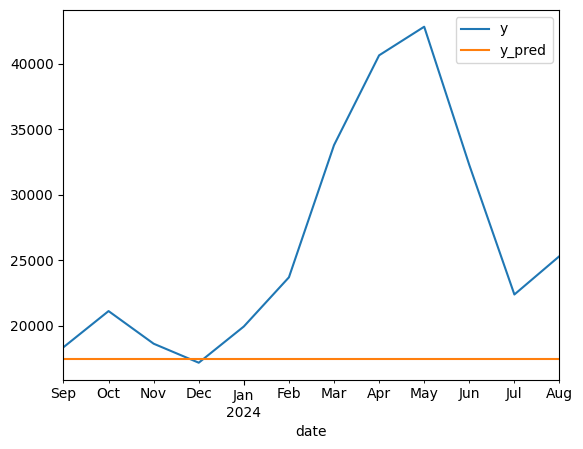

In [8]:
family = "Zapatillas Urban"
brand = "adidas"
df_preds[(df_preds["family"] == family) & (df_preds["brand"] == brand)][["y", "y_pred"]].plot()